# Implementing Shap Heatmaps for interpretability

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap

In [15]:
import tensorflow as tf
print(tf.__version__)

2.17.0


# Loading and Organizing Data

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rt_xls = pd.ExcelFile('Data/rpt.00013061.0000000000000000.RTMLZHBSPP_2011.xlsx')
print(rt_xls.sheet_names)

rt = pd.concat(
    (pd.read_excel(rt_xls, sheet_name=s) for s in rt_xls.sheet_names),
    ignore_index=True
)

zone = "LZ_HOUSTON"

rtm_z = rt[rt["Settlement Point Name"] == zone].copy()



mask_24 = rtm_z["Delivery Hour"] == 24
rtm_z.loc[mask_24, "Delivery Hour"] = 0
rtm_z.loc[mask_24, "Delivery Date"] = (
    pd.to_datetime(rtm_z.loc[mask_24, "Delivery Date"]) + pd.Timedelta(days=1)
).dt.strftime("%m/%d/%Y")

rtm_z["datetime"] = pd.to_datetime(
    rtm_z["Delivery Date"] + " " + rtm_z["Delivery Hour"].astype(int).astype(str),
    format="%m/%d/%Y %H"
)

rtm_z = rtm_z.set_index("datetime").sort_index()
rtm_z = rtm_z.rename(columns={"Settlement Point Price": "RTM_15min"})

rtm_hourly = rtm_z["RTM_15min"].groupby("datetime").mean().to_frame("RTM")


fed_funds_df = pd.read_csv('Data/federal_funds_2011.csv')


fed_funds_rate = fed_funds_df


# columns: ['observation_date', 'FEDFUNDS']
fed_funds_rate['observation_date'] = pd.to_datetime(fed_funds_rate['observation_date'])
ffr_df = fed_funds_rate.set_index('observation_date').sort_index()

# start at first day of first month
start = ffr_df.index.min().normalize()               # 2011-01-01 00:00

# end = last day of last month, 23:00
last_month_end = ffr_df.index.max().to_period('M').to_timestamp('M')  # 2011-12-31 00:00
end = last_month_end + pd.Timedelta(hours=23)                          # 2011-12-31 23:00

# hourly index for the full year
hourly_idx = pd.date_range(start, end, freq='H')

# reindex and forward-fill monthly values
ffr_hourly = ffr_df.reindex(hourly_idx, method='ffill')

print(ffr_hourly.index[0], ffr_hourly.index[-1])
# 2011-01-01 00:00:00 2011-12-31 23:00:00
print(ffr_hourly.shape)

ffr_hourly = ffr_hourly[:-1]


import netCDF4

temp = netCDF4.Dataset('Data/1yeartexasfocused/data_stream-oper_stepType-instant.nc')

cloud = netCDF4.Dataset('Data/1yeartexasfocused/6d54a8966bd3e929ebba9c39b86323fe.nc')

wind = netCDF4.Dataset('Data/1yeartexasfocused/b19d9b13a745c2fbd15c421befa61f76.nc')


lat = np.asarray(temp.variables['latitude'])
lon = np.asarray(temp.variables['longitude'])
# temperature 2 meters above ground level
t2m = np.asarray(temp.variables['t2m']) # shape (time, lat, lon)

cloud_cover = np.asarray(cloud.variables['tcc']) # shape (time, lat, lon)
v_component = np.asarray(wind.variables['v10']) # shape (time, lat, lon)
u_component = np.asarray(wind.variables['u10']) # shape (time, lat, lon)



# time is in hours (31 * 24 = 744 hours)
t2m = t2m[1:, :, :]  # last 744 hours of December 2010
cloud_cover = cloud_cover[1:, :, :]
v_component = v_component[1:, :, :]
u_component = u_component[1:, :, :]
print(t2m.shape)
print(cloud_cover.shape)
print(v_component.shape)
print(u_component.shape) 


import numpy as np

# assuming u_component and v_component are already time × lat × lon
wind_speed = np.sqrt(u_component**2 + v_component**2)

print(wind_speed.shape)  # (time, lat, lon) same as u/v


# # taking the sub grid of interest (around Texas)
# temp_sub = t2m[:, 208:257, 1006:1064]
# temp_sub.shape

temp_sub = t2m
print(temp_sub.shape)

import yfinance as yf

data = yf.download(
    "SPY",
    start="2011-01-01",
    end="2012-01-01",
    interval="1d"
)





# 2. Convert daily SPY data to hourly array of length 744


spy_daily = data["Close"]

idx = pd.date_range("2010-12-01", "2010-12-31 23:00", freq="H")


spy_daily_full = spy_daily.asfreq("D").ffill()
idx = pd.date_range("2011-01-01", "2011-12-31", freq="D")
spy_daily_full = spy_daily.reindex(idx).ffill()


start = spy_daily_full.index.min()
end   = spy_daily_full.index.max()

idx_hourly = pd.date_range(start, end + pd.Timedelta(hours=23), freq="H")

spy_hourly = spy_daily_full.reindex(idx_hourly, method="ffill")[:-1]

print(rtm_hourly.shape)
print(spy_hourly.shape)

print(temp_sub.shape)
print(ffr_hourly.shape)



import numpy as np
import pandas as pd

T = rtm_hourly.shape[0]  # 744 for one month
feature_cols = ["RT", "SPY", "FFR", "hour", "dow", "month"]

idx = pd.date_range("2010-12-01", periods=T, freq="H")  # adjust start

df_scalar = pd.DataFrame(index=idx)
df_scalar["RT"]   = rtm_hourly.squeeze()
df_scalar["SPY"]  = spy_hourly.squeeze()
df_scalar["FFR"]  = ffr_hourly.astype("float32")

# calendar features
df_scalar["hour"]  = df_scalar.index.hour
df_scalar["dow"]   = df_scalar.index.dayofweek
df_scalar["month"] = df_scalar.index.month



# grid_all = np.stack(
#     [temp_sub, cloud_cover, u_component, v_component],
#     axis=-1
# ).astype("float32")

grid_all = np.stack(
    [temp_sub, cloud_cover, wind_speed],
    axis=-1
).astype("float32")


print(grid_all.shape) 


# grid_mean = grid_all.mean(axis=(0, 1, 2), keepdims=True)  # (1,1,1,4)
# grid_std  = grid_all.std(axis=(0, 1, 2), keepdims=True) + 1e-6
# grid_all  = (grid_all - grid_mean) / grid_std

mask_valid = ~df_scalar[feature_cols + ["RT"]].isna().any(axis=1)
df_scalar = df_scalar[mask_valid]
grid_all = grid_all[mask_valid.to_numpy()]  # keep t2m in sync with time axis

past_hours = 24
future_hours = 24


def make_supervised_spatiotemporal(df_scalar, grid_all, past_hours, future_hours, feature_cols):
    # df_scalar: DataFrame (T, n_scalar)
    # t2m_grid:  array (T, H, W)
    values = df_scalar[feature_cols].to_numpy().astype("float32")  # (T, n_scalar)
    rt     = df_scalar["RT"].to_numpy().astype("float32")          # (T,)
    
    
    n_scalar   = values.shape[1]
    T, H, W, C = grid_all.shape
    
    X_grid_list = []
    X_seq_list  = []
    Y_list      = []

    # here we get samples by sliding a window over time (each step is a sample of data)
    
    for t in range(T - past_hours - future_hours + 1): # so we dont overshoot the time axis
        # temperature block
        grid_block = grid_all[t : t + past_hours]                # (past_hours, H, W)
        grid_block = grid_block[..., np.newaxis]                  # (past_hours, H, W, 1)
        
        # scalar time-series block
        seq_block = values[t : t + past_hours]                    # (past_hours, n_scalar)
        
        # future RT prices
        future_rt = rt[t + past_hours : t + past_hours + future_hours]  # (24,)
        
        X_grid_list.append(grid_block)
        X_seq_list.append(seq_block)
        Y_list.append(future_rt)
    
    X_grid = np.stack(X_grid_list, axis=0)   # (n_samples, past_hours, H, W, 1)
    X_seq = np.stack(X_seq_list, axis=0)    # (n_samples, past_hours, n_scalar)
    Y = np.stack(Y_list, axis=0)        # (n_samples, future_hours)
    
    return X_grid, X_seq, Y

X_grid, X_seq, Y = make_supervised_spatiotemporal(
    df_scalar, grid_all, past_hours, future_hours, feature_cols
)

print("X_grid:", X_grid.shape)  # (n_samples, 24, H, W, 1)
print("X_seq: ", X_seq.shape)   # (n_samples, 24, n_scalar)
print("Y:     ", Y.shape)       # (n_samples, 24)




['Jan_1', 'Feb_2', 'Mar_3', 'Apr_4', 'May_5', 'Jun_6', 'Jul_7', 'Aug_8', 'Sep_9', 'Oct_10', 'Nov_11', 'Dec_12']


/tmp/ipykernel_13129/887866240.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_idx = pd.date_range(start, end, freq='H')


2011-01-01 00:00:00 2011-12-31 23:00:00
(8760, 1)


/tmp/ipykernel_13129/887866240.py:114: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed

(8759, 20, 36)
(8759, 20, 36)
(8759, 20, 36)
(8759, 20, 36)
(8759, 20, 36)
(8759, 20, 36)
(8759, 1)
(8759, 1)
(8759, 20, 36)
(8759, 1)



/tmp/ipykernel_13129/887866240.py:130: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range("2010-12-01", "2010-12-31 23:00", freq="H")
/tmp/ipykernel_13129/887866240.py:141: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_hourly = pd.date_range(start, end + pd.Timedelta(hours=23), freq="H")
/tmp/ipykernel_13129/887866240.py:159: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range("2010-12-01", periods=T, freq="H")  # adjust start


(8759, 20, 36, 3)
X_grid: (7919, 24, 20, 36, 3, 1)
X_seq:  (7919, 24, 6)
Y:      (7919, 24)


In [17]:
split = int(len(X_grid) * 0.8)
Xg_train, Xg_test = X_grid[:split], X_grid[split:]
Xs_train, Xs_test = X_seq[:split],  X_seq[split:]
Y_train,  Y_test  = Y[:split],      Y[split:]

# shap values

In [18]:
from tensorflow.keras.layers import (
    Input, ConvLSTM2D, BatchNormalization, GlobalAveragePooling2D, Flatten,
    Conv1D, GlobalAveragePooling1D, Dense, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

n_scalar = X_seq.shape[2]
H, W, C = X_grid.shape[2], X_grid.shape[3], X_grid.shape[4]

# spatio-temporal grid branch
grid_in = Input(shape=(past_hours, H, W, C), name="grid_input")
xg = ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    activation="relu",
    return_sequences=False
)(grid_in)
xg = BatchNormalization()(xg)
xg = Flatten()(xg)
#xg = GlobalAveragePooling2D()(xg)   # -> (batch, 16)

# time series branch
seq_in = Input(shape=(past_hours, n_scalar), name="seq_input")
xs = Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu")(seq_in)
xs = Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu")(xs)
xs = GlobalAveragePooling1D()(xs)   # -> (batch, 32)

# combine
x = Concatenate()([xg, xs])         # (batch, 48)
x = Dense(256, activation="relu")(x) # previously did not use regularization
x = Dense(128, activation="relu")(x)
out = Dense(future_hours, name="output")(x)   # 24-hour forecast

model = Model(inputs=[grid_in, seq_in], outputs=out)
model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ grid_input          │ (None, 24, 20,    │          0 │ -                 │
│ (InputLayer)        │ 36, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_input           │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 20, 36,    │     11,008 │ grid_input[0][0]  │
│ (ConvLSTM2D)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 32)    │        608 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 36,    │         64 │ conv_lstm2d_1[0]… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 24, 32)    │      3,104 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 11520)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv1d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 11552)     │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  2,957,568 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 24)        │      3,096 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,008,344 (11.48 MB)

 Trainable params: 3,008,312 (11.48 MB)

 Non-trainable params: 32 (128.00 B)

In [19]:
model.load_weights("large_scale_predictor.weights.h5")

/home/yash/miniconda3/envs/shap_clean/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
import tensorflow as tf

base_model = tf.keras.models.load_model("large_scale_predictor_model.keras")

k = 13  # horizon index 0..23

# full output: (None, 24)
y_full = base_model.outputs[0]

# pick horizon k as a 1-D tensor: (None,)
y_k_1d = y_full[..., k]

# explicitly expand to 2-D: (None, 1)
y_k_2d = tf.keras.layers.Lambda(lambda t: tf.expand_dims(t, axis=-1))(y_k_1d)

model_h = tf.keras.Model(
    inputs=base_model.inputs,
    outputs=y_k_2d,
)

print("model_h output shape:", model_h.output_shape)
# should print: (None, 1)


model_h output shape: (None, 1)


In [21]:
import numpy as np
import shap

# background samples
idx_bg = np.random.choice(len(X_grid), size=50, replace=False)
Xg_bg  = X_grid[idx_bg].astype("float32")   # shape: (50, past_hours, H, W, C)
Xs_bg  = X_seq[idx_bg].astype("float32")    # shape: (50, past_hours, n_scalar)

# samples to explain
idx_explain = np.random.choice(len(Xg_test), size=20, replace=False)
Xg_ex  = Xg_test[idx_explain].astype("float32")
Xs_ex  = Xs_test[idx_explain].astype("float32")

print("Xg_bg:", Xg_bg.shape)
print("Xs_bg:", Xs_bg.shape)
print("Xg_ex:", Xg_ex.shape)
print("Xs_ex:", Xs_ex.shape)
print("model_h output:", model_h.output_shape)

Xg_bg = Xg_bg[:, :, :, :, :, 0]
Xg_ex = Xg_ex[:, :, :, :, :, 0]



print("grid input shape :", model_h.inputs[0].shape, "bg:", Xg_bg.shape)
print("seq  input shape :", model_h.inputs[1].shape, "bg:", Xs_bg.shape)

#explainer = shap.DeepExplainer(model_h, [Xg_bg, Xs_bg])

explainer = shap.GradientExplainer(model_h, [Xg_bg, Xs_bg])

shap_grid, shap_seq = explainer.shap_values([Xg_ex, Xs_ex])


Xg_bg: (50, 24, 20, 36, 3, 1)
Xs_bg: (50, 24, 6)
Xg_ex: (20, 24, 20, 36, 3, 1)
Xs_ex: (20, 24, 6)
model_h output: (None, 1)
grid input shape : (None, 24, 20, 36, 3) bg: (50, 24, 20, 36, 3)
seq  input shape : (None, 24, 6) bg: (50, 24, 6)


In [22]:
np.shape(Xs_ex)

(20, 24, 6)

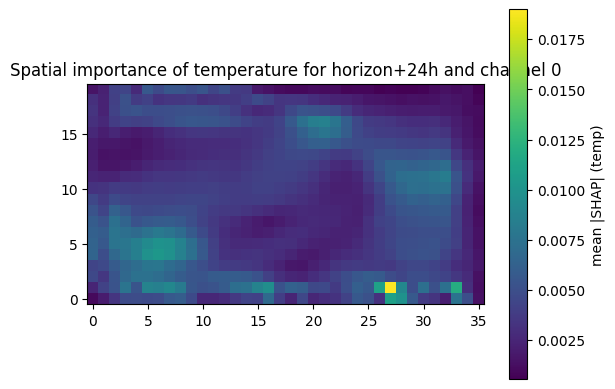

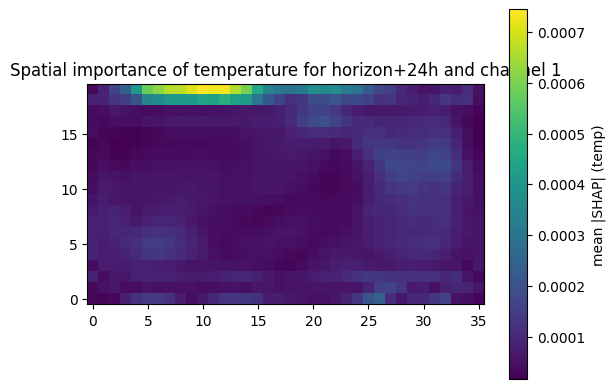

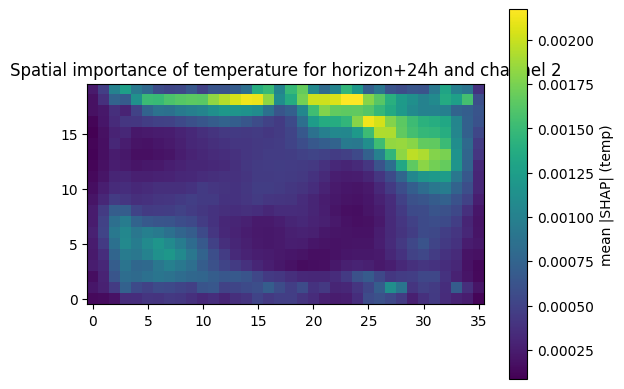

In [32]:
# average |SHAP| over examples and time, per grid cell and channel
# shap_grid: (n_explain, past_hours, H, W, C)
spatial_importance = np.mean(np.abs(shap_grid), axis=(0, 1))  # (H, W, C)

# e.g., for temp channel:
# temp, cloud, wind_speed

for i in range(3):
    spatial_temp = spatial_importance[:, :, i]

    plt.imshow(spatial_temp, origin="lower")
    plt.colorbar(label="mean |SHAP| (temp)")
    plt.title(f"Spatial importance of temperature for horizon+24h and channel {i}")
    plt.show()